In [1]:
%matplotlib inline

import cv2
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

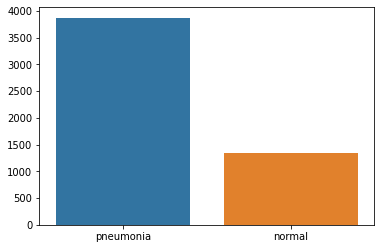

In [2]:
pneumonia_dir = '/content/drive/MyDrive/Python/chest_xray/train/PNEUMONIA'
normal_dir = '/content/drive/MyDrive/Python/chest_xray/train/NORMAL'

pneumonia_files = os.listdir(pneumonia_dir)
normal_files = os.listdir(normal_dir)

x = ['pneumonia', 'normal']
y = [len(pneumonia_files), len(normal_files)]

sns.barplot(x, y)
plt.show()

In [3]:
training_dir = "/content/drive/MyDrive/Python/chest_xray/train"
validation_dir = "/content/drive/MyDrive/Python/chest_xray/test"
test_dir = "/content/drive/MyDrive/Python/chest_xray/val"

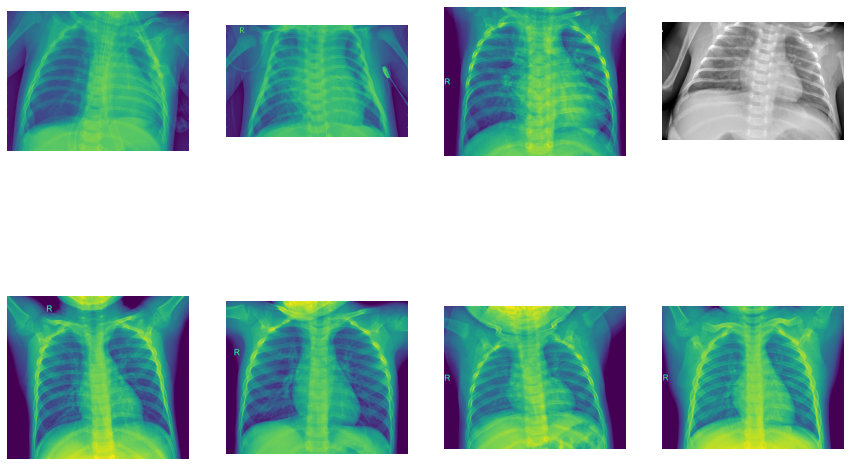

In [4]:
pneumonia_imgs = [os.path.join(pneumonia_dir, fname) for fname in pneumonia_files[:4]]

normal_imgs = [os.path.join(normal_dir, fname) for fname in normal_files[:4]]

f, axs = plt.subplots(2,4)
f.set_figheight(10)
f.set_figwidth(15)

for i, img_path in enumerate(pneumonia_imgs + normal_imgs):
  if i < 4:
    img = mpimg.imread(img_path)
    axs[0,i].imshow(img)
    axs[0,i].grid(False)
    axs[0,i].axis('off')
  else:
    img = mpimg.imread(img_path)
    axs[1,i-4].imshow(img)
    axs[1,i-4].grid(False)
    axs[1,i-4].axis('off')

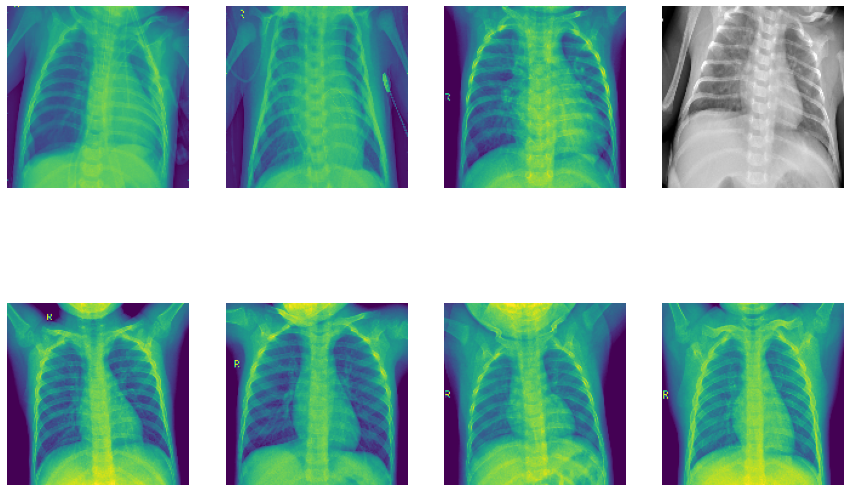

In [5]:
pneumonia_imgs = [os.path.join(pneumonia_dir, fname) for fname in pneumonia_files[:4]]

normal_imgs = [os.path.join(normal_dir, fname) for fname in normal_files[:4]]

f, axs = plt.subplots(2,4)
f.set_figheight(10)
f.set_figwidth(15)

dim = (150, 150)

for i, img_path in enumerate(pneumonia_imgs + normal_imgs):
  if i < 4:
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    resized_img = cv2.resize(img, dim)
    axs[0,i].imshow(resized_img)
    axs[0,i].grid(False)
    axs[0,i].axis('off')
  else:
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    resized_img = cv2.resize(img, dim)
    axs[1,i-4].imshow(resized_img)
    axs[1,i-4].grid(False)
    axs[1,i-4].axis('off')

In [6]:
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=25,
      width_shift_range=0.1,
      height_shift_range=0.1,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [7]:
train_generator = training_datagen.flow_from_directory(
    training_dir,
    target_size=dim,
    class_mode='binary',
    color_mode='grayscale',
    batch_size=32)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=dim,
    class_mode='binary',
    color_mode='grayscale',
    batch_size=32,
    shuffle = False)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=dim,
    class_mode='binary',
    color_mode='grayscale',
    batch_size=32)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [8]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [9]:
model = Sequential([
    # The first convolution
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(150, 150, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    # The second convolution
    Conv2D(64, (3,3), activation='relu'),
    Dropout(0.1),
    BatchNormalization(),
    MaxPooling2D(2,2),
    # The third convolution
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),  
    # The fourth convolution
    Conv2D(128, (3,3), activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D(2,2),
    # The fith convolution
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    # Flatten the results
    Flatten(),
    # 512 neuron hidden layer
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 73, 73, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0

In [11]:
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/2))

opt = tf.keras.optimizers.RMSprop(learning_rate=1e-8)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics = ['accuracy'])

history = model.fit(train_generator, epochs=15, validation_data = validation_generator, callbacks=[lr_schedule], verbose=1)

Epoch 1/15
163/163 [==============================] - 68s 390ms/step - loss: 1.0149 - accuracy: 0.4125 - val_loss: 0.7093 - val_accuracy: 0.3750
Epoch 2/15
163/163 [==============================] - 62s 383ms/step - loss: 0.9861 - accuracy: 0.4374 - val_loss: 0.7258 - val_accuracy: 0.4583
Epoch 3/15
163/163 [==============================] - 63s 385ms/step - loss: 0.9538 - accuracy: 0.4535 - val_loss: 0.7110 - val_accuracy: 0.5609
Epoch 4/15
163/163 [==============================] - 63s 386ms/step - loss: 0.8576 - accuracy: 0.4992 - val_loss: 0.6743 - val_accuracy: 0.6074
Epoch 5/15
163/163 [==============================] - 63s 385ms/step - loss: 0.6247 - accuracy: 0.6903 - val_loss: 0.4848 - val_accuracy: 0.7628
Epoch 6/15
163/163 [==============================] - 63s 384ms/step - loss: 0.4240 - accuracy: 0.8014 - val_loss: 0.3666 - val_accuracy: 0.8253
Epoch 7/15
163/163 [==============================] - 63s 386ms/step - loss: 0.3110 - accuracy: 0.8570 - val_loss: 0.3496 - val_ac

(1e-08, 0.1, 0.0, 1.0)

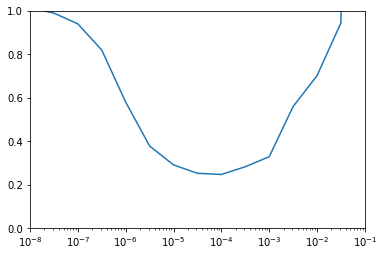

In [12]:
lrs = 1e-8 * (10 ** (np.arange(15) / 2))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 1])

In [13]:
keras.backend.clear_session()

In [14]:
model = Sequential([
    # The first convolution
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(150, 150, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    # The second convolution
    Conv2D(64, (3,3), activation='relu'),
    Dropout(0.1),
    BatchNormalization(),
    MaxPooling2D(2,2),
    # The third convolution
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),  
    # The fourth convolution
    Conv2D(128, (3,3), activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D(2,2),
    # The fith convolution
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    # Flatten the results
    Flatten(),
    # 512 neuron hidden layer
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

In [15]:
lr_schedule = LearningRateScheduler(lambda epoch: 9e-5 * 0.9**(epoch))

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

opt = tf.keras.optimizers.RMSprop(learning_rate=7e-5)
lr_metric = get_lr_metric(opt)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics = ['accuracy', lr_metric])
history = model.fit(train_generator, epochs=20, validation_data = validation_generator, callbacks=[lr_schedule, checkpoint], verbose=1)

Epoch 1/20
163/163 [==============================] - 65s 388ms/step - loss: 0.3320 - accuracy: 0.8634 - lr: 9.0000e-05 - val_loss: 0.8682 - val_accuracy: 0.6250 - val_lr: 9.0000e-05
Epoch 2/20
163/163 [==============================] - 63s 384ms/step - loss: 0.2125 - accuracy: 0.9141 - lr: 8.1000e-05 - val_loss: 2.4107 - val_accuracy: 0.6250 - val_lr: 8.1000e-05
Epoch 3/20
163/163 [==============================] - 63s 386ms/step - loss: 0.1699 - accuracy: 0.9333 - lr: 7.2900e-05 - val_loss: 3.3454 - val_accuracy: 0.6250 - val_lr: 7.2900e-05
Epoch 4/20
163/163 [==============================] - 63s 384ms/step - loss: 0.1642 - accuracy: 0.9406 - lr: 6.5610e-05 - val_loss: 1.2267 - val_accuracy: 0.6619 - val_lr: 6.5610e-05
Epoch 5/20
163/163 [==============================] - 63s 385ms/step - loss: 0.1535 - accuracy: 0.9404 - lr: 5.9049e-05 - val_loss: 0.4114 - val_accuracy: 0.8798 - val_lr: 5.9049e-05
Epoch 6/20
163/163 [==============================] - 62s 383ms/step - loss: 0.1370 -

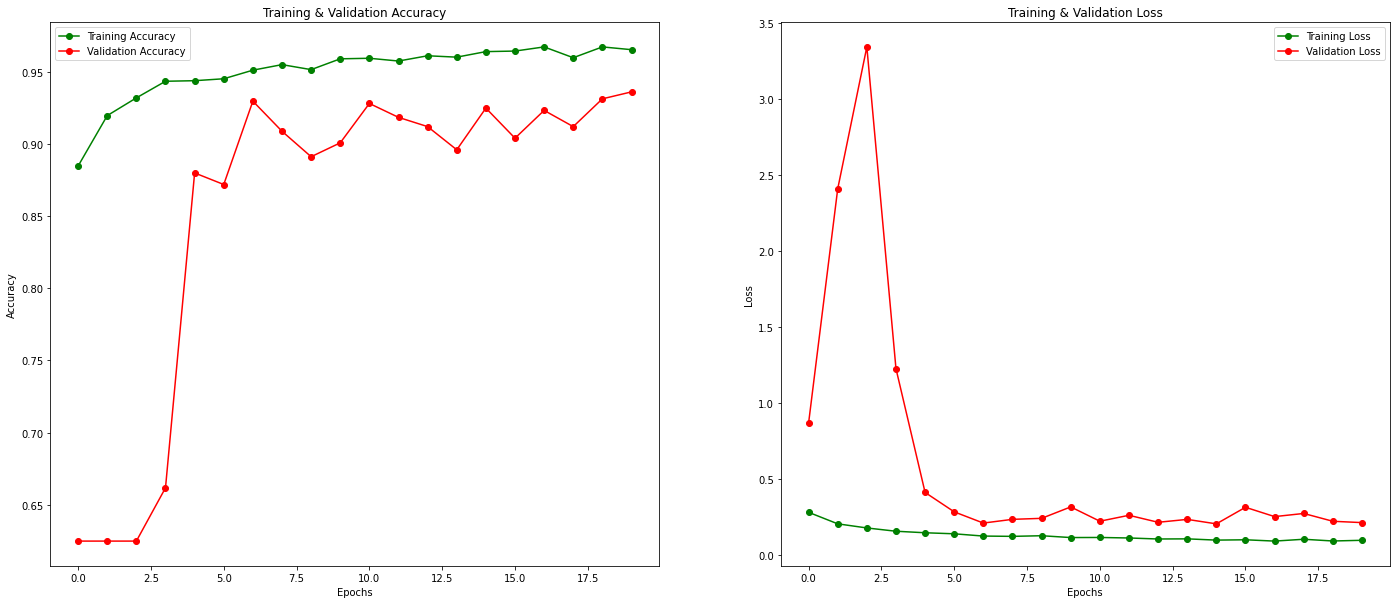

In [20]:
fig , ax = plt.subplots(1,2, figsize=(24,10))

epochs = [i for i in range(20)]
metrics = [history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss']]

for i, metric in enumerate(['Accuracy', 'Loss']):
  ax[i].plot(epochs, metrics[2*i] , 'o-' , label = f'Training {metric}', color = 'g')
  ax[i].plot(epochs, metrics[2*i+1] , 'o-' , label = f'Validation {metric}', color = 'r')
  ax[i].set_title(f'Training & Validation {metric}')
  ax[i].legend()
  ax[i].set_xlabel('Epochs')
  ax[i].set_ylabel(f'{metric}')

plt.show()

In [16]:
def convert_to_class(predictions):
  predictions = predictions.flatten()
  predictions = np.rint(predictions)
  return predictions

In [ ]:
model.load_weights('best_model.h5')

In [17]:
actual_classes = validation_generator.classes

predictions = model.predict(validation_generator)
predicted_classes = convert_to_class(predictions)

In [18]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.97      0.85      0.91       234
Pneumonia (Class 1)       0.92      0.98      0.95       390

           accuracy                           0.94       624
          macro avg       0.94      0.92      0.93       624
       weighted avg       0.94      0.94      0.93       624



In [21]:
conf_matrix = confusion_matrix(actual_classes, predicted_classes)

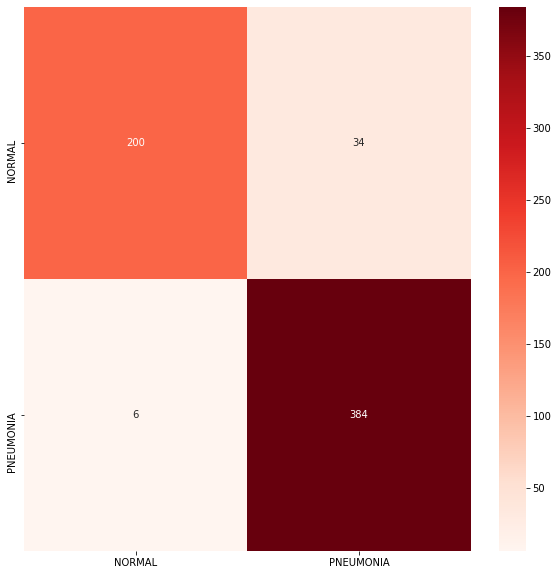

In [28]:
plt.figure(figsize = (10,10))
labels = ['NORMAL', 'PNEUMONIA']
sns.heatmap(conf_matrix, cmap="Reds", annot = True, fmt='g', xticklabels = labels, yticklabels = labels);